借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [86]:
# pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()
# from attention_utils import get_activations
import  pandas as pd
import  numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from typing import Tuple 
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [87]:


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y
     

In [88]:



# keras.layers.Activation('linear')

In [89]:


dfstate = pd.read_csv("./data/states.txt")
dfstate["start"] = dfstate.apply(
    lambda row: row["date"] + " " + row["start_time"], axis=1
)
dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
dfstate["label"] = dfstate.pop("state").str.strip()
# 转为时间类型
dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
# dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv("./data/states.csv")
print(dfstate.head(), dfstate.shape)
 

         date start_time  end_time               start                 end  \
0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   

  label  
0     装  
1     卸  
2     装  
3     卸  
4     装   (56, 6)


In [90]:
# 定义读取，处理数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果

    inputDF.insert(0, "label", "-")

    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]

        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass

    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF


def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
df17 = read_data("./data/data_17.xlsx")
df21 = read_data("./data/data_21.xlsx")
df22 = read_data("./data/data_22.xlsx")
df23 = read_data("./data/data_23.xlsx")


In [91]:

data = pd.concat([df17, df21], axis=0, ignore_index=True).drop([ "轨迹时间"], axis = 1)
number_types = [np.number]
label_types = ["object"]
time_types = ["datetime64[ns]"]
numeric_col_names = data.select_dtypes(include=number_types).columns.tolist()
label_col_names = data.select_dtypes(include=label_types).columns.tolist()
time_col_names = data.select_dtypes(include=time_types).columns.tolist()
print(numeric_col_names,label_col_names,time_col_names)
print(data.columns)
print(data.shape)

df22= df22.drop([ "轨迹时间"], axis = 1)
df23= df23.drop([ "轨迹时间"], axis = 1)


['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff', 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff', 'su_y_diff', 'su_z_diff', '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶'] ['label'] ['时间']
Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '速度', '估计重量', '原始重量加速度', '稳定重量加速度',
       '原始重量加速度_二阶', '稳定重量加速度_二阶'],
      dtype='object')
(41494, 28)


In [92]:


# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)

# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN'] 

# plt.show()


In [93]:
 

# 假设我们有一个包含字符串类别的列表或数组
categories = ["apple", "banana", "apple", "orange", "banana", "grape"]

# 创建LabelEncoder实例
le = LabelEncoder()

# 拟合数据以获取类别到整数的映射
le.fit(categories)

# 显示已学习到的类别及其对应的整数标签
print('类别映射:', dict(zip(le.classes_, le.transform(le.classes_))))

# 将原始数据转化为整数编码
encoded_categories = le.transform(categories)
print('编码后的类别:', encoded_categories)

# 如果需要，还可以通过inverse_transform还原原始类别
decoded_categories = le.inverse_transform(encoded_categories)

类别映射: {'apple': 0, 'banana': 1, 'grape': 2, 'orange': 3}
编码后的类别: [0 1 0 3 1 2]


### 改各自层数！

In [189]:


def normalize(inpudf: pd.DataFrame,numeric_col_names:list,label_col_names:list,time_col_names:list) -> Tuple[pd.DataFrame , MinMaxScaler,LabelEncoder]:
    inpudf=inpudf.copy()
    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = MinMaxScaler(feature_range=(-10, 10))
    scaler.fit(inpudf[numeric_col_names])

    # （label）标准化
    le = LabelEncoder()
    #["装", "卸",'-']
    le.fit(inpudf[label_col_names])

    # newdata=np.array(inpudf)
    # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
    for col in numeric_col_names:
        inpudf[col] = le.fit_transform(inpudf[col])

    # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
    for col in label_col_names:
        inpudf[col] = le.fit_transform(inpudf[col])
    # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
    # 将所有时间列转换为Unix时间戳（单位为秒）
    for col in time_col_names:
        print(inpudf[col].astype(np.int64),inpudf[col].astype(np.int64)/1e9)
        inpudf[col] = (            
            inpudf[col].astype(np.int64) / 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf,scaler,le


# 反标准化


def denormalize(inpudf: pd.DataFrame,scaler:MinMaxScaler,le:LabelEncoder) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""

    # 数值型数据标准化-
    inpudf[numeric_col_names] = scaler.inverse_transform(inpudf[numeric_col_names])

    # 类别数据（label）标准化-
    for col in label_col_names:
        inpudf[col] = le.inverse_transform(inpudf[col])

    # 时间数据标准化-
    for col in time_col_names:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf 

In [190]:

 

numeric_col_names = [ '原始重量', '稳定重量', '轴重',
                'wpu_z',
                'su_z',            
                '速度']
# delete some 
#  '原始重量_diff', '稳定重量_diff', '轴重_diff','su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff','估计重量',    'su_x_diff','su_y_diff', 'su_z_diff',  'su_ad', ,'wpu_x', 'wpu_y', 'su_x', 'su_y',


# ['原始重量', '稳定重量', '轴重', 'su_ad', 
#                 'wpu_x', 'wpu_y', 'wpu_z', 
#                 'su_x', 'su_y', 'su_z', 
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff', 
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff', 
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶'] 
label_col_names = ['label']
time_col_names = ['时间']

data=data[numeric_col_names+label_col_names+time_col_names] # 去掉无用列
display(data)
#Normalized
data,scaler,le = normalize(data,numeric_col_names,label_col_names,time_col_names)
display(data)
# feature_col_names = numeric_col_names +  time_col_names
feature_col_names = numeric_col_names  # 暂时去掉 时间
X = data[feature_col_names]
Y = data[label_col_names]

x_train, x_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.33, shuffle= False)


feature_col_num =  len(feature_col_names)
 
# Input image dimensions
 

# Convert class vectors to binary class matrices. This uses 1 hot encoding.
# y_train_binary = keras.utils.to_categorical(y_train,num_classes)
# y_test_binary = keras.utils.to_categorical(y_test,num_classes)
 
x_train = x_train.reshape(-1, feature_col_num)
x_test = x_test.reshape(-1, feature_col_num)

display(y_train.shape,y_test.shape)
y_train = y_train.reshape(-1, )
y_test = y_test.reshape(-1, )
display(y_train,y_test)

,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
0,2115,1,1240,2542,1384,0,0,0.0
1,2099,1,1241,2569,1384,0,0,0.0
2,2032,1,1230,2556,1385,0,0,0.0
3,2074,1,1238,2556,1386,0,0,0.0
4,2055,1,1231,2557,1384,0,0,0.0
...,...,...,...,...,...,...,...,...
41489,543,0,475,3963,1171,0,0,0.0
41490,536,0,472,3949,1171,0,0,0.0
41491,498,0,467,3959,1168,0,0,0.0
41492,521,0,465,3958,1170,0,0,0.0


0        0
1        0
2        0
3        0
4        0
        ..
41489    0
41490    0
41491    0
41492    0
41493    0
Name: 时间, Length: 41494, dtype: int64 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41489    0.0
41490    0.0
41491    0.0
41492    0.0
41493    0.0
Name: 时间, Length: 41494, dtype: float64


g:\dev\.anaconda\Miniconda\envs\py39_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
0,2115,1,1240,2542,1384,0,0,0.0
1,2099,1,1241,2569,1384,0,0,0.0
2,2032,1,1230,2556,1385,0,0,0.0
3,2074,1,1238,2556,1386,0,0,0.0
4,2055,1,1231,2557,1384,0,0,0.0
...,...,...,...,...,...,...,...,...
41489,543,0,475,3963,1171,0,0,0.0
41490,536,0,472,3949,1171,0,0,0.0
41491,498,0,467,3959,1168,0,0,0.0
41492,521,0,465,3958,1170,0,0,0.0


(27800, 1)

(13694, 1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [96]:

 

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset:pd.DataFrame, look_back:int):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back),1:]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y



def attention_model():
    # inputs = Input(((data.shape[1],1)))
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters = 64,kernel_size =32,dilation_rate=2,padding="same", activation="relu")(inputs)
    # x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(drop)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True,name='bilstm'))(x)
    lstm_out = Dropout(drop)(lstm_out)

    #attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(lstm_out)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model
     

In [97]:
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))



2.10.0
[]
Available GPU devices: []


In [191]:


batch_size = feature_col_num
epochs = 50
drop=0.2

model =models.Sequential([
    tf.keras.layers.Input( batch_input_shape=(None,feature_col_num,),batch_size=batch_size, name='input'), 
    layers.Dense(units=5),
    # layers.Conv1D(5, (3), activation=tf.nn.relu),
    # layers.MaxPooling1D(pool_size=2),
    layers.Dropout(drop),
    layers.Flatten(),
    # layers.Dense(units=8, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(units=4, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(units=1, activation='linear')
])

model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer="sgd",
    metrics=['accuracy'],
)
# model.build()
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 5)                 35        


                                                                 
 dropout_21 (Dropout)        (None, 5)                 0         
                                                                 
 flatten_20 (Flatten)        (None, 5)                 0         
                                                                 
 dense_72 (Dense)            (None, 4)                 24        
                                                                 
 dense_73 (Dense)            (None, 1)                 5         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [192]:
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [193]:

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tf_callback])

Epoch 1/50
4634/4634 [==============================] - 5s 977us/step - loss: nan - accuracy: 0.9797 - val_loss: nan - val_accuracy: 0.9752
Epoch 2/50
4634/4634 [==============================] - 4s 939us/step - loss: nan - accuracy: 0.9800 - val_loss: nan - val_accuracy: 0.9752
Epoch 3/50
4634/4634 [==============================] - 4s 927us/step - loss: nan - accuracy: 0.9800 - val_loss: nan - val_accuracy: 0.9752
Epoch 4/50
4634/4634 [==============================] - 4s 937us/step - loss: nan - accuracy: 0.9800 - val_loss: nan - val_accuracy: 0.9752
Epoch 5/50
4634/4634 [==============================] - 4s 940us/step - loss: nan - accuracy: 0.9800 - val_loss: nan - val_accuracy: 0.9752
Epoch 6/50
4634/4634 [==============================] - 4s 957us/step - loss: nan - accuracy: 0.9800 - val_loss: nan - val_accuracy: 0.9752
Epoch 7/50
4634/4634 [==============================] - 4s 941us/step - loss: nan - accuracy: 0.9800 - val_loss: nan - val_accuracy: 0.9752
Epoch 8/50
4634/4634

KeyboardInterrupt: 

In [101]:

# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1 
# 网页中可以查看模型训练过程

In [102]:
model.save("./C_L_A.h5")

In [103]:

data22,scaler22,le22 = normalize(df22,numeric_col_names,label_col_names,time_col_names)


X22 = data22[feature_col_names]
Y22 = data22[label_col_names]


x_train22,  y_train22 = np.asarray(X22), np.asarray(Y22)


 
x_train = x_train22.reshape(-1, feature_col_num) 

# display(y_train22.shape )
# y_train22 = y_train22.reshape(-1, ) 
 

predY=model.predict(x_train,batch_size=batch_size)
# predY=predY.reshape(-1, )

print('y_train22.shape',y_train22.shape)
print ("predY.shape", predY.shape)


  71/1214 [>.............................] - ETA: 1s  

g:\dev\.anaconda\Miniconda\envs\py39_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1214/1214 [==============================] - 1s 665us/step
y_train22.shape (27913, 1)
predY.shape (27913, 1)


array([    0,     1,     2, ..., 27910, 27911, 27912], dtype=int64)

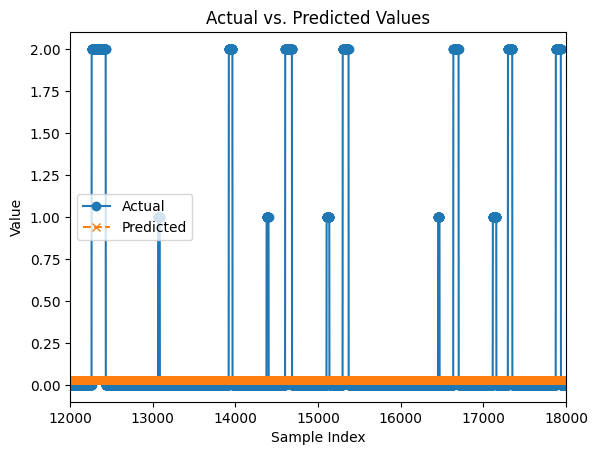

In [104]:
# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)

# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN'] 

# plt.show()
times=df22[time_col_names].index.to_numpy()
display(times)
plt.plot(times,y_train22, label='Actual', marker='o')
plt.plot(times,predY, label='Predicted', linestyle='--', marker='x')

ax = plt.gca()
ax.set_xlim(left=12000, right=18000)
# 添加标题和标签
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图形
plt.show()

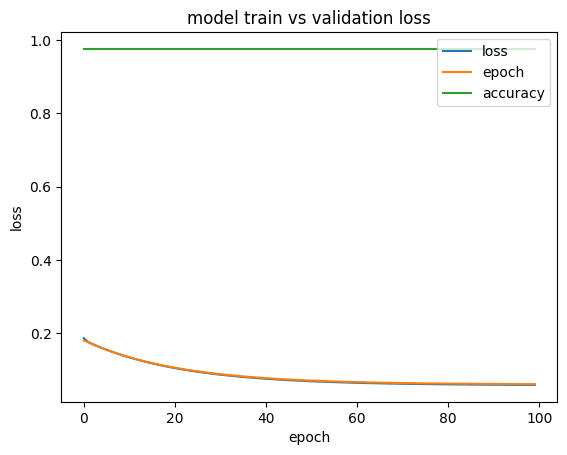

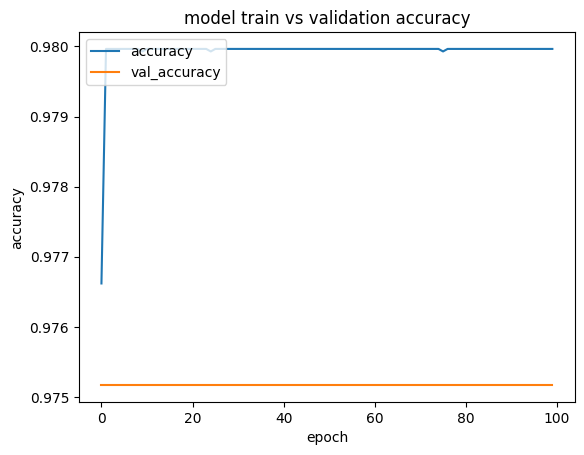

In [105]:
#display(history.history)
plt.plot( history.history['loss'])
plt.plot( history.history['val_loss'])
plt.plot( history.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'epoch','accuracy'], loc='upper right')
plt.show()
plt.plot( history.history['accuracy'])
plt.plot( history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
 

In [106]:
display(df22.columns)

Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '速度', '估计重量'],
      dtype='object')

In [107]:

df22,scaler22,le22 = normalize(df22,numeric_col_names,label_col_names,time_col_names)
df23,scaler23,le23 = normalize(df23,numeric_col_names,label_col_names,time_col_names)

x_df22 = df22[numeric_col_names]
y_df22 = df22['label']
y_df22 = keras.utils.to_categorical(np.asfarray(y_df22),num_classes) 
x_df22=np.asfarray(x_df22)
x_df22 = x_df22.reshape(len(x_df22), feature_col_num,1)
results22 = model.predict(x_df22)
display(results22)

g:\dev\.anaconda\Miniconda\envs\py39_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
g:\dev\.anaconda\Miniconda\envs\py39_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NameError: name 'keras' is not defined

In [ ]:

fig_acc = plt.figure(figsize=(9, 9))
plt.plot(results22[0:27000])
plt.plot(y_df22[0:27000])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.xlim((19000, 23000))
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [ ]:


print('以下是CNN_biLSTM_Attention误差')
print('R^2决定系数：',r2_score(test_Y[000:14000],results[00:14000]))
print('RMSE为：',np.sqrt(mean_squared_error(test_Y[2500:18000],results[2500:18000])))
print('MAPE为：',(abs(results[9000:15000] -test_Y[9000:15000])/ test_Y[9000:15000]).mean())

In [ ]:
test_new=[]
predict_new=[] 

for k in range(len(results)):
    if test_Y[k]!=0:
        test_new.append(test_Y[k])
        predict_new.append(results[k])

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.fabs((y_true - y_pred) / y_true))
mape = format(MAPE(test_new, predict_new), '.4f') 
mape